# PubMed 20k RCT Sentence Classification (5 classes)

Goal: classify each sentence from a medical abstract into one of:
background / objective / methods / results / conclusions

Model: DistilBERT fine-tuned on a subset (thermal-safe)
Metrics: Accuracy + Macro F1


Loading the data

link to dataset: https://huggingface.co/datasets/pietrolesci/pubmed-20k-rct

In [9]:
from datasets import load_dataset
ds = load_dataset("pietrolesci/pubmed-20k-rct")

Setup + reproducibility

In [46]:
import numpy as np
import random
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [47]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Cleaning the dataset so that we only have text and label:

In [10]:
ds_clean = ds.remove_columns([
    "abstract_id",
    "sentence_id",
    "uid",
    "embedding_all-mpnet-base-v2",
    "embedding_multi-qa-mpnet-base-dot-v1",
    "embedding_all-MiniLM-L12-v2"
])


In [24]:
ds_clean["train"].features


{'labels': ClassLabel(names=['background', 'conclusions', 'methods', 'objective', 'results']),
 'text': Value('string')}

In [25]:
for i in range(10):
    print(ds_clean['train'][i])

{'labels': 3, 'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'}
{'labels': 2, 'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'}
{'labels': 2, 'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'}
{'labels': 2, 'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .'}
{'labels': 2, 'text': 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .'}
{'labels': 2, 'text': 'Serum levels of interleukin @ ( IL-@ ) , IL-

Tokenizer + tokenization

In [11]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [13]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

In [14]:
ds_tok = ds_clean.map(tokenize, batched=True)

Map:   0%|          | 0/29672 [00:00<?, ? examples/s]

In [15]:
ds_tok.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"])



In [30]:
ds_tok["train"][0]


{'labels': tensor(3),
 'input_ids': tensor([  101,  2000,  8556,  1996, 21150,  1997,  1030,  3134,  1997,  3679,
          2659,  1011, 13004,  8700,  3653,  2094,  8977, 12898,  2638,  1999,
          9229,  3255,  1010, 12969,  1010,  1998, 22575,  2659,  1011,  3694,
         21733,  1999,  1996,  2460,  2744,  1998,  3251,  1996,  3466,  2052,
          2022,  8760,  2012,  1030,  3134,  1999,  3080,  6001,  2007,  8777,
          2000,  5729,  6181,  9808,  2618, 10441, 15265, 14778,  2483,  1006,
          1051,  2050,  1007,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

Model init

In [31]:
num_labels = ds_tok["train"].features["labels"].num_classes
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics

In [32]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

In [33]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]}
    

Due to hardware limitation, the training was done on a subset

In [16]:
train_ds = ds_tok["train"].shuffle(seed=42).select(range(20000))
val_ds= ds_tok["validation"].shuffle(seed=42).select(range(4000))


Training arguments

In [44]:
training_args = TrainingArguments(
    output_dir="./outputs/distilbert_subset",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,              
    load_best_model_at_end=True,
    report_to="none"
)



Train

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



C:\Users\ASUS\AppData\Local\Temp\ipykernel_9312\3441088952.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [46]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.392000,0.388615,0.863500,0.801597
2,0.306200,0.404729,0.866500,0.806389
3,0.224500,0.442016,0.864750,0.802757


TrainOutput(global_step=3750, training_loss=0.3091353810628255, metrics={'train_runtime': 514.0501, 'train_samples_per_second': 116.72, 'train_steps_per_second': 7.295, 'total_flos': 993558643200000.0, 'train_loss': 0.3091353810628255, 'epoch': 3.0})

Loading the model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("./outputs/distilbert_subset/checkpoint-2500"  )
tokenizer = AutoTokenizer.from_pretrained("./outputs/distilbert_subset/checkpoint-2500")


Evaluation

In [17]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


predictions

In [18]:
predictions = []
labels = []
with torch.no_grad():
    for batch in val_ds:
        inputs = {
            "input_ids": batch["input_ids"].unsqueeze(0),
            "attention_mask": batch["attention_mask"].unsqueeze(0),
        }
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        predictions.append(preds.item())
        labels.append(batch["labels"])


Confusion matrix

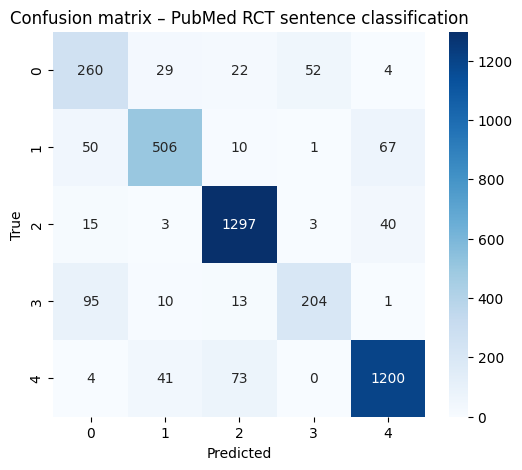

In [21]:
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – PubMed RCT sentence classification")
plt.show()


In [23]:
val_raw = ds_clean["validation"].select(range(len(val_ds)))


Error analysis table

In [26]:
errors = []
for i in range(len(val_ds)):
    if predictions[i] != labels[i]:
        errors.append({
            "text": val_raw[i]["text"],
            "true_label": labels[i],
            "pred_label": predictions[i]
        })
error_df = pd.DataFrame(errors)
error_df.head(10)


,text,true_label,pred_label
0,"Opioid antagonists ( e.g. , naltrexone ) and p...",tensor(3),0
1,The general consensus suggests explicit instru...,tensor(1),4
2,"We compare these results with previous , contr...",tensor(2),4
3,"Over a @-month period , of the @,@ appointment...",tensor(0),3
4,"In a randomised controlled open study , nurses...",tensor(3),0
5,"Before and after a @-day course , the nurses u...",tensor(3),1
6,The number of correct answers after e-learning...,tensor(1),4
7,The study showed no differences in learning ou...,tensor(0),1
8,Previous investigation showed that the volume-...,tensor(3),0
9,The subjects who received the volume-time curv...,tensor(3),0


In [28]:
label_names = ds_clean["train"].features["labels"].names
label_names


['background', 'conclusions', 'methods', 'objective', 'results']

In [29]:
error_df["true_label_name"] = error_df["true_label"].apply(
    lambda x: label_names[int(x)])
error_df["pred_label_name"] = error_df["pred_label"].apply(
    lambda x: label_names[int(x)])
error_df[["text", "true_label_name", "pred_label_name"]].head(10)


,text,true_label_name,pred_label_name
0,"Opioid antagonists ( e.g. , naltrexone ) and p...",objective,background
1,The general consensus suggests explicit instru...,conclusions,results
2,"We compare these results with previous , contr...",methods,results
3,"Over a @-month period , of the @,@ appointment...",background,objective
4,"In a randomised controlled open study , nurses...",objective,background
5,"Before and after a @-day course , the nurses u...",objective,conclusions
6,The number of correct answers after e-learning...,conclusions,results
7,The study showed no differences in learning ou...,background,conclusions
8,Previous investigation showed that the volume-...,objective,background
9,The subjects who received the volume-time curv...,objective,background


In [27]:
error_df.shape

(533, 3)

“Top 3” most common confusions

In [33]:
error_df["error_type"] = (error_df["true_label_name"] + " → " + error_df["pred_label_name"])
top_errors=error_df["error_type"].value_counts().head(3)


In [36]:
top_errors

error_type
objective → background    95
results → methods         73
conclusions → results     67
Name: count, dtype: int64

In [ ]:
pd.set_option("display.max_colwidth", None)   
pd.set_option("display.width", 0)    


In [45]:
error_df[error_df['error_type']=='objective → background'].text.head(10)

0                                                                                                                                       Opioid antagonists ( e.g. , naltrexone ) and positive modulators of - aminobutyric-acidA ( GABAA ) receptors ( e.g. , alprazolam ) modestly attenuate the abuse-related effects of stimulants like amphetamine .
4                                                                                                                                                                                                      In a randomised controlled open study , nurses from hospitals and primary healthcare were randomised to either e-learning or classroom teaching .
8                                                                                                                                                                                                             Previous investigation showed that the volume-time curve technique could be an alternative for endotrach

In [49]:
error_df.to_csv('error.csv')